# Code for CUQIpy paper 2, section 2.7. Parameterizing the initial condition using Karhunen–Lo`eve (KL) expansion

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from cuqi.distribution import Gaussian, JointDistribution
from cuqi.geometry import Continuous1D, KLExpansion, StepExpansion
from cuqi.pde import TimeDependentLinearPDE
from cuqi.model import PDEModel
from cuqi.sampler import CWMH
from cuqi.array import CUQIarray
from paper_figures import plot_figure5

The following code cell is a setup similar to what was presented in sections 2.2 to 2.6 (heat_1D_part1.ipynb). We rewrite it here because we need it to set up the 1D heat-based Bayesian inverse problem cases discussed in section 2.7.  

In [2]:
n_grid = 100   # Number of solution nodes
h = 1/(n_grid+1)   # Space step size
grid = np.linspace(h, 1-h, n_grid)

tau_max = 0.01 # Final time (in sections 2.2 to 2.6, tau_max=0.02)
cfl = 5/11 # The cfl condition to have a stable solution
dt_approx = cfl*h**2 # Defining approximate time step size
n_tau = int(tau_max/dt_approx)+1 # Number of time steps
tau = np.linspace(0, tau_max, n_tau)

c = 1
f = np.zeros(n_grid)
D_c = c**2 * ( np.diag(-2*np.ones(n_grid), 0) +
np.diag(np.ones(n_grid-1), -1) +
np.diag(np.ones(n_grid-1), 1) ) / h**2

def PDE_form(g, tau_current):
    return (D_c, f, g)

g_custom =1/30*(1-np.cos(2*np.pi*(1-grid)/(1)))\
                +1/30*np.exp(-2*(10*(grid-0.5))**2)+\
                 1/30*np.exp(-2*(10*(grid-0.8))**2)


KL geoemtry:

In [3]:
G_KL = KLExpansion(grid, decay_rate=1.5, normalizer=10, num_modes=20)

In [4]:
# Wrap g_custom into a CUQIarray
g_custom = CUQIarray(g_custom, is_par=False, geometry=G_KL)

### Case 1:

Note that the next code cell content was discussed in sections 2.1-2.6, here 
we make slight modification to accommodate for the first case of the three KL 
expansion cases presented in section 2.7 (the case with observation everywhere 
and 0.1% noise).

In [5]:
PDE_1 = TimeDependentLinearPDE(PDE_form, tau, grid_sol=grid)

G_cont_1 = Continuous1D(grid)
A_case_1 = PDEModel(PDE_1, range_geometry=G_cont_1, domain_geometry=G_KL)
y_custom_1 = A_case_1(g_custom)

noise_level_1 = 0.001
s_noise_1 =1.0/np.sqrt(n_grid)* noise_level_1*np.linalg.norm(y_custom_1)

x = Gaussian(np.zeros(G_KL.par_dim), 1, geometry=G_KL)
prior_samples = x.sample(5)

y_1 = Gaussian(A_case_1(x), s_noise_1**2, geometry=G_cont_1)

y_obs_1 = y_1(x=g_custom).sample()

joint_1 = JointDistribution(x, y_1)
posterior_1 = joint_1(y_1=y_obs_1)

scale_1 = np.ones(G_KL.par_dim)
scale_1[0] = 0.5
my_sampler_1 = CWMH(posterior_1, scale=scale_1)
posterior_samples_1 = my_sampler_1.sample_adapt(N=50000)

Sample 50000 / 50000

Average acceptance rate all components: 0.404761 



We create a list of case 1 data to be passed to the plotting method:

In [6]:
case1_data = [g_custom, y_custom_1, y_obs_1, posterior_samples_1]

### Case 2:

Note that the next code cell content was discussed in sections 2.1-2.6, here 
we make slight modification to accommodate for the second case of the three KL 
expansion cases presented in section 2.7 (the case with observation everywhere 
and 5% noise).

In [7]:
PDE_2 = PDE_1

y_custom_2 = y_custom_1

A_case_2 = A_case_1

noise_level_2 = 0.05
s_noise_2 =1.0/np.sqrt(n_grid)* noise_level_2*np.linalg.norm(y_custom_2)

y_2 = Gaussian(A_case_2(x), s_noise_2**2, geometry=A_case_2.range_geometry)

y_obs_2 = y_2(x=g_custom).sample()

joint_2 = JointDistribution(x, y_2)
posterior_2 = joint_2(y_2=y_obs_2)

scale_2 = np.ones(G_KL.par_dim)
scale_2[0] = 0.5
my_sampler_2 = CWMH(posterior_2, scale=scale_2)

posterior_samples_2 = my_sampler_2.sample_adapt(50000)

Sample 50000 / 50000

Average acceptance rate all components: 0.564094 



We create a list of case 2 data to be passed to the plotting method:

In [8]:
case2_data = [g_custom, y_custom_2, y_obs_2, posterior_samples_2]

### Case 3:

Note that the next code cell content was discussed in sections 2.1-2.6, here 
we make slight modification to accommodate for the third case of the three KL 
expansion cases presented in section 2.7 (the case with observation on the left
half of the domain and 5% noise).

In [9]:
PDE_3 = TimeDependentLinearPDE(PDE_form, tau, grid_sol=grid, grid_obs=grid[:50])

G_cont_3 = Continuous1D(grid[:50])
A_case_3 = PDEModel(PDE_3, range_geometry=G_cont_3, domain_geometry=G_KL)
y_custom_3 = A_case_3(g_custom)

noise_level_3 = 0.05
s_noise_3 =1.0/np.sqrt(n_grid)* noise_level_3*np.linalg.norm(y_custom_3)

y_3 = Gaussian(A_case_3(x), s_noise_3**2, geometry=G_cont_3)

y_obs_3 = y_3(x=g_custom).sample()

joint_3 = JointDistribution(x, y_3)
posterior_3 = joint_3(y_3=y_obs_3)

scale_3 = np.ones(G_KL.par_dim)
scale_3[0] = 0.5
my_sampler_3 = CWMH(posterior_3, scale=scale_3)

posterior_samples_3 = my_sampler_3.sample_adapt(50000)

Sample 50000 / 50000

Average acceptance rate all components: 0.561768 



We create a list of case 3 data to be passed to the plotting method:

In [10]:
case3_data = [g_custom, y_custom_3, y_obs_3, posterior_samples_3]

### Code cell for plotting figure 5:

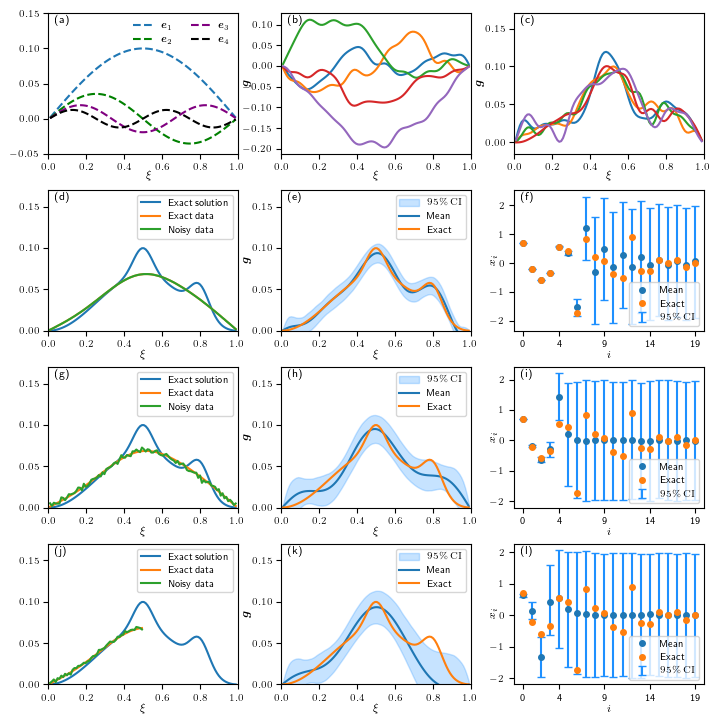

In [20]:
fig_dir = './figs/'
version = 'v9'
plot_figure5(fig_dir, version, G_KL, 
                 prior_samples, 
                 case1_data,
                 case2_data,
                 case3_data)
